# Import useful stuff

In [2]:
# The igraph library
from igraph import *

# Numpy for enhanced math array management
import numpy as np

#Usata per calcolare il logaritmo
from math import log

# statistical tools (we only use ECDF)
from statsmodels.distributions.empirical_distribution import ECDF

# Mathematical plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# use to control whether to show the entire cell output or only the last_expr (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to generate random numbers
from random import *
import sys
# to fit power law distributions
from powerlaw import *

# INTRODUZIONE
#### Facebook (WOSN) is undirected network contains friendship data of Facebook users. 
#### A node represents a user and an edge represents a friendship between two users.

# Parameters

In [3]:
#Select the dataset
#dataset="./dataset/socfb-wosn-friends.cut.edges"           #BIGGEST  -  64K nodi, 1269K link      
#dataset="./dataset/socfb-wosn-friends.cut.sb.43K.edges"    #MEDIUM   -  43K nodi,  739K link
dataset="./dataset/socfb-wosn-friends.cut.sb.10K.edges"     #MINOR    -  10K nodi,  230K link

#Select if the dataset is directed or undirected
#direct=True
direct=False

#Select if connection-mode is weak or or strong
#This is the way to find Giant component
conn_mode="WEAK"
#conn_mode="STRONG"

# Punto 1) e Punto 2)
## Reading graphs from files & data frames / Writing graphs to files

In [4]:
fg = read(dataset, format = "ncol", directed = False)
summary(fg, verbosity=1, max_rows = 25, edge_list_format = 'edgelist')

IGRAPH UN-- 10000 229693 -- 
+ attr: name (v)
+ edges (vertex names):
        edge  
[0]    5--22  
[1]    5--683 
[2]    5--821 
[3]    5--469 
[4]    5--639 
[5]    5--814 
[6]    5--1528
[7]    5--1640
[8]    5--1642
[9]    5--1643
[10]   5--1648
[11]   5--2548
[12]   5--4246
[13]   5--4503
[14]   5--4964
[15]   9--23  
[16]   9--2058
[17]   9--309 
[18]   9--2175
[19]   469--9 
[20]   639--9 
[21]   1528--9
[22]   1640--9
[23]   9--47  
[24]   9--100 


# Punto 3.a)
### Il Giant Component esiste?

In [5]:
# Check whether the graph is connected or not
if fg.is_connected(mode = "STRONG")==True:
    print ("The graph is STRONGLY CONNECTED. \n\nNodes are mutally connected. All Graph is the Giant Component")
    giant_component=fg
elif fg.is_connected(mode = "WEAK")==True:
    print ("The graph is WEAKLY CONNECTED. \n\nNodes are connected. All Graph is the Giant Component")
    giant_component=fg
else:
    print ("The graph is NOT CONNECTED. \n\nIt is necessary to find the Giant Component")    
    # Compute the connected components in the graph
    #   - "WEAK" does not consider the direction of edges
    #All clusters
    clusters_list = fg.clusters(mode = conn_mode)
    # the number of clusters
    print ("Number of clusters: ",len(clusters_list))    
    # the membership of vertices in the clusters. Every pos has the cluster_ID associated to the vertex
    #clusters_list.membership[0:10]
    # the sizes of the clusters
    #print ("Clusters size:")
    #clusters_list.sizes()[0:10]

    #Does Giant COmponent exist? 
    #GC esiste se contiene una frazione >> di nodi rispetto a logN (N =numero totale di nodi nel grafo), 
    #Gli altri componenti sono nell’ordine di logN

    
    #Trashold
    trashold=10*log(fg.vcount(),10)
    print ("Trashold is:", trashold)
    
    
    # sizes (sorted, first 20 elements)
    sorted_clusters = sorted(clusters_list.sizes(), reverse=True)
    print("Lista dei cluster ordinata per dimensione:")
    sorted_clusters[0:19]
    
    
    #bigger_cluster=max(clusters_list.sizes())
    print ("Bigger Cluster:", sorted_clusters[0])
    print ("2nd Bigger Cluster:", sorted_clusters[1])
    
    if sorted_clusters[0] > trashold and sorted_clusters[1] < trashold/2:
        print ("GIANT COMPONENT EXIST!!!")
    
        #Select the Giant Componet (the biggest cluster)
        giant_component = clusters_list.giant()
    
        # number of vertices and edges in the original graph
        print ("Numero di nodi del giant componet ", giant_component.vcount())
        print ("Numero di nodi totali ", fg.vcount())
        print ("GC: ",giant_component.vcount()*100/fg.vcount(),"%")
    
        #From this time we consider GC as the only one cluster 
        #fg=giant_component
    else :
        print ("GIANT COMPONENT DOES NOT EXIST!!!")
        exit(0)
gc=giant_component

The graph is STRONGLY CONNECTED. 

Nodes are mutally connected. All Graph is the Giant Component


### Graph of major nodes (degree > 120)

In [6]:
# Select only nodes with degree > 120 from the Giant Component
vs = giant_component.vs.select(_degree_gt = 120)
fb_g_sub = giant_component.induced_subgraph(vs)

try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}
    
visual_style["bbox"] = (600,600)
visual_style["label"] = []
visual_style["layout"] = fb_g_sub.layout_fruchterman_reingold()
visual_style["vertex_size"] = 5
visual_style["vertex_color"] = 'red'
visual_style["vertex_shape"] = 'circle'
visual_style["edge_arrow_size"] = 0.2
#visual_style["edge_width"] = np.array(fb_g_sub.es["weight"])/10

plot(fb_g_sub, **visual_style)

### Erdos-Raneyi (ranndom graph)

In [11]:
# genero una rete con lo stesso numero di nodi e archi ma secondo il modello del ranndom graph (Erdos Renyi)
er_p = mean(gc.degree()) / gc.vcount()
er_graph = Graph.Erdos_Renyi(gc.vcount(), er_p)

# Erdos Renyi giant component
er_gc = er_graph.clusters(mode = "WEAK").giant()
print("Erdos Renyi GC node count: {}".format(er_gc.vcount()))
print("Original GC node count: {}".format(gc.vcount()))
print("Erdos Renyi GC edge count: {}".format(er_gc.ecount()))
print("Original GC edge count: {}".format(gc.ecount()))

Erdos Renyi GC node count: 10000
Original GC node count: 10000
Erdos Renyi GC edge count: 229397
Original GC edge count: 229693


### Barabási–Albert model


In [12]:
# Analyse the entire graph
ba_graph = Graph.Barabasi(gc.vcount(), m=23)
# Settato m=23 per ottenere circa lo stesso numero di link della nostra rete

# take only the Giant Component
ba_gc = ba_graph.clusters(mode = "WEAK").giant()
print ("Barabasi-Albert model GC node count: ", ba_gc.vcount())
print("Original GC node count: ", gc.vcount())
print ("Barabasi-Albert model GC edge count: ", ba_gc.ecount())
print("Original GC edge count: ", gc.ecount())

Barabasi-Albert model GC node count:  10000
Original GC node count:  10000
Barabasi-Albert model GC edge count:  229724
Original GC edge count:  229693


### Watts-Strogatz graphs

In [13]:
# The value of <k> and the rewiring probability
avg_deg_fb = mean(gc.degree())
ws_p = 0.1
ws_graph = Graph.Watts_Strogatz(1, gc.vcount(), int(round(avg_deg_fb)), ws_p)

# take only the Giant Component
ws_gc = ws_graph.clusters(mode = "WEAK").giant()
print ("Watts-Strogatz model GC node count: ", ws_gc.vcount())
print("Original GC node count: ", gc.vcount())
print ("Watts-Strogatz model GC edge count: ", ws_gc.ecount())
print("Original GC edge count: ", gc.ecount())

Watts-Strogatz model GC node count:  10000
Original GC node count:  10000
Watts-Strogatz model GC edge count:  460000
Original GC edge count:  229693


# Punto 3.b) Degree Distribution

In [21]:
# Il nosro grafo è non direzionale
# In oogni caso applico la funzione as_undirect.
# Questo perchè a volte nei dataset si possono trovare due o più link che collegano gli stessi nodi
# take the undirected version of the Giant Component 
# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)
giant_component_undir = giant_component.as_undirected(combine_edges = "sum")
gc=giant_component_undir


# degree distribution
# plt.figure(1)
# Con all calcola il grado del grafo non direzionale, resstituisce un array di gradi per ogni nodo
fb_deg = gc.degree(mode='all') 
print("DEGREE range:") 
print("Max degree: {}".format(max(fb_deg)))
print("Min degree: {}".format(min(fb_deg)))
print("Grado medio: {}".format(mean(fb_deg)))

id_max = np.argmax(fb_deg)
print("Max degree node ID: {}".format(id_max))

er_avr_deg = er_gc.vcount()*er_p
print("Erdos-Ranyi. Grado medio della rete equivalente: ", er_avr_deg)
ba_avr_deg = ba_gc.degree(mode='all')
print("Batabasi. Grado medio della rete equivalente: ", mean(ba_avr_deg))
ws_avr_deg = ws_gc.degree(mode='all')
print("Watts-Strogats. Grado medio della rete equivalente: ", mean(ws_avr_deg))

DEGREE range:
Max degree: 1098
Min degree: 1
Grado medio: 45.93859999999997
Max degree node ID: 492
Erdos-Ranyi. Grado medio della rete equivalente:  45.93859999999997
Batabasi. Grado medio della rete equivalente:  45.94479999999998
Watts-Strogats. Grado medio della rete equivalente:  92.00000000000023


## Punto 3.b) Assortatività

Assortativity
Pearson's correlation coefficient: 0.0694862700376148


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'degree k')

Text(0, 0.5, 'Neighbors degree')

Text(0.5, 1.0, '$knn$ index for the FB Giant Component')

Text(0.5, 0, 'degree k')

Text(0, 0.5, 'Average degree of neighbors')

Text(0.5, 1.0, '$knnk$ index for the FB Giant Component')

<Figure size 432x288 with 0 Axes>

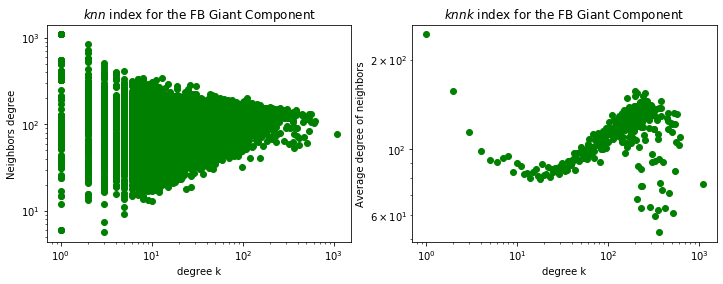

In [25]:
# degree correlation
# assortativity
print("Assortativity")
# METODO del coefficiente di corerelazione di PEARSON {-1,0,1}
print("Pearson's correlation coefficient: {}".format(gc.assortativity_degree())) 
# restituisce l'indice di correlazione fra i gradi dei nodi vicini.
# se è positivo, assortativo, negativo disassortativo, se prossimo allo zero non si puo dire

default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])
 
# METODO del grado medio dei vicini
fb_knn, fb_knnk = gc.knn() #restituisce due vettori
plt.figure(6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)
ax1.loglog(gc.degree(), fb_knn, 'go')
ax1.set_xlabel("degree k")
ax1.set_ylabel("Neighbors degree")
ax1.set_title("$knn$ index for the FB Giant Component")

ax2.loglog(range(1,max(gc.degree())+1), fb_knnk, 'go')
ax2.set_xlabel("degree k")
ax2.set_ylabel("Average degree of neighbors")
ax2.set_title("$knnk$ index for the FB Giant Component")
plt.savefig("assortatyvity.png")
#plt.close()

# Punto 3.b) Clustering

In [29]:
# CLUSTERING
# C1 e C2 --> 0 Poco clusterizzata
# C1 e C2 --> 1 Molto clusterizzata
# my graph
# mode = 0 means that nodes with less than two neighbours will have zero transitivity
c1_idx = gc.transitivity_undirected() #C1
c2_idx = gc.transitivity_avglocal_undirected(mode="zero") # C2
c_random_idx = 1/gc.vcount()

# Erdos Renyi
c1_er_idx = er_gc.transitivity_undirected() #C1
c2_er_idx = er_gc.transitivity_avglocal_undirected(mode="zero") # C2

# Barabasi-Albert
c1_ba_idx = ba_gc.transitivity_undirected() #C1
c2_ba_idx = ba_gc.transitivity_avglocal_undirected(mode="zero") # C2

# clustering coefficient
c1_ws_idx = ws_gc.transitivity_undirected() #C1
c2_ws_idx = ws_gc.transitivity_avglocal_undirected(mode="zero") # C2

print("Clustering C1: {}".format(c1_idx))
print("Clustering C2: {}".format(c2_idx))
#print("Theoretic Clustering Random Graph: {}".format(c_random_idx))
print("ER Clustering C1: {}".format(c1_er_idx))
print("ER Clustering C2: {}".format(c2_er_idx))
print("BA Clustering C1: {}".format(c1_ba_idx))
print("BA Clustering C2: {}".format(c2_ba_idx))
print("WS Clustering C1: {}".format(c1_ws_idx))
print("WS Clustering C2: {}".format(c2_ws_idx))

Clustering C1: 0.15963124513639235
Clustering C2: 0.2650973730927101
ER Clustering C1: 0.00459076314773412
ER Clustering C2: 0.004589494923640475
BA Clustering C1: 0.020373473976264576
BA Clustering C2: 0.019886906012571735
WS Clustering C1: 0.39397892326347206
WS Clustering C2: 0.39556137771344224


## Punto 3.b) Community Detection

In [ ]:
# comunity detection
idxs = np.argwhere(np.array(gc.degree()) > 3).flatten()
subgraph = gc.induced_subgraph(idxs)

# Modularity-based Community Detection
# Fastgreedy algorithm
vd = subgraph.community_fastgreedy()

# The number of detected communities
print("Number of detected communities: {}".format(vd.optimal_count))
# convert to a cluster object to access additional information
vd_clust = vd.as_clustering()

# the sizes of the communities
print("size of communities: {}".format(vd_clust.sizes()))

# plot the communities
#out = plot(vd_clust, layout=gc.layout_fruchterman_reingold(), mark_groups = True)
#out.save("comunities.png")
plot(vd_clust, layout=gc.layout_fruchterman_reingold(), mark_groups = True)
    
# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()

### Degree density and CCDF

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a lin-lin scale')

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a log-log scale')

<Figure size 432x288 with 0 Axes>

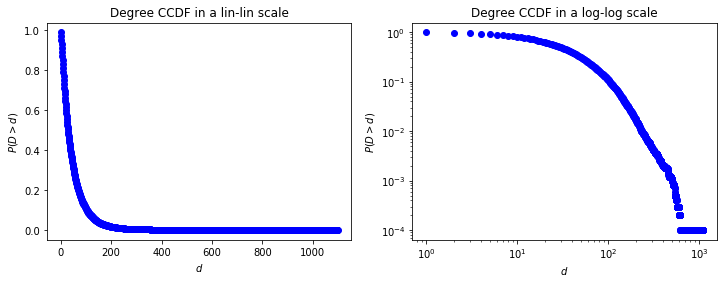

In [189]:
# CCDF
deg_cdf = ECDF(fb_deg) # generatiìore di funzioni, restituisce una funzione interpolante per la CDF
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])
    
#plotting CCDF
plt.figure(3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)
degs = np.arange(1,max(fb_deg)+1) # tutti i gradi della mia rete
ax1.plot(degs, 1-deg_cdf(degs), 'bo')
ax1.set_xlabel("$d$")
ax1.set_ylabel("$P(D>d)$")
ax1.set_title("Degree CCDF in a lin-lin scale")

ax2.loglog(degs, 1-deg_cdf(degs), 'bo')
ax2.set_xlabel("$d$")
ax2.set_ylabel("$P(D>d)$")
ax2.set_title("Degree CCDF in a log-log scale")
plt.savefig("CCDF.png")




### FITTING DELLA CCDF 



Calculating best minimal value for power law fit
/home/rocco/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


PL exponents: (xmin=40) 2.53; (auto xmin=169.00) 4.25


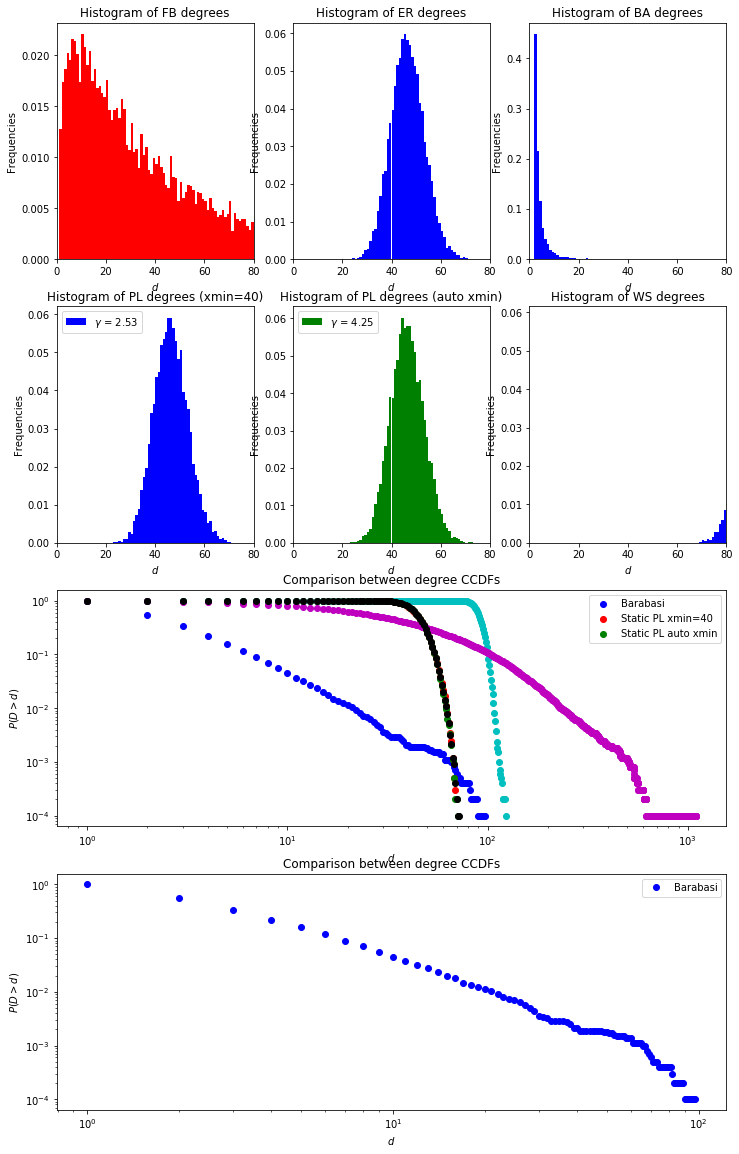

In [200]:
 #############################################################
# fitting with power law
    

# fitting della power law
xmin = 40 #può essere impostato e passato alla funzione fit
fit_pl_auto = Fit(gc.degree()) # restituisce un oggetto con il campo alpha (esponente pl che meglio fitta i miei dati) 
                                                # e xmin (valore minimo del grado per cui il fitting è valido)
fit_pl = Fit(gc.degree(), xmin=xmin)

xmin_auto = fit_pl_auto.xmin
exp_pl_auto = fit_pl_auto.alpha
exp_pl = fit_pl.alpha
print ("PL exponents: (xmin=%d) %.2f; (auto xmin=%.2f) %.2f" % (xmin, exp_pl, xmin_auto, exp_pl_auto))

# genero due reti PL equivalenti con alpha e xmin trovati
N = gc.vcount()
M = gc.ecount()
pl_graph_auto = Graph.Static_Power_Law(N, int(round(M)), xmin_auto)
pl_graph_auto_gc = pl_graph_auto.clusters(mode='weak').giant()

pl_graph = Graph.Static_Power_Law(N, int(round(M)), xmin)
pl_graph_gc = pl_graph.clusters(mode='weak').giant()


# plotting
fig_sizes = (fig_sizes[0], 5*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 4x3 Grid Specification
gs = gridspec.GridSpec(4, 3)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
# the fourth plot spans the entire second row
ax7 = plt.subplot(gs[2,:])
ax8 = plt.subplot(gs[3,:])


# compute and plot the histogram of FB degrees
d_fb = gc.degree()
_,_,_ = ax1.hist(d_fb, bins=range(1,max(d_fb)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of FB degrees")

# compute and plot the histogram of ER degrees
deg_er = er_gc.degree()
_,_,_ = ax2.hist(deg_er, bins=range(1,max(deg_er)+2), density = True, color = 'blue')
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of ER degrees")

# compute and plot the histogram of BA degrees
d_ba = ba_gc.degree()
_,_,_ = ax3.hist(d_ba, bins=range(1,max(d_ba)+2), density = True, color = 'blue')
_ = ax3.set_xlim(0,80)
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("Frequencies")
_ = ax3.set_title("Histogram of BA degrees")

# compute and plot the histogram of Static Power Law degrees with set xmin
d_pl = pl_graph_gc.degree()
_,_,_ = ax4.hist(d_pl, bins=range(1,max(d_pl)+2), density = True, color = 'blue', label = "$\gamma$ = %.2f" % exp_pl)
_ = ax4.set_xlim(0,80)
_ = ax4.set_xlabel("$d$")
_ = ax4.set_ylabel("Frequencies")
_ = ax4.set_title("Histogram of PL degrees (xmin=%d)" % xmin)
_ = ax4.legend()

# compute and plot the histogram of Static Power law degrees with auto xmin
d_pl_auto = pl_graph_auto_gc.degree()
_,_,_ = ax5.hist(d_pl_auto, bins=range(1,max(d_pl_auto)+2), density = True, color = 'green', label = "$\gamma$ = %.2f" % exp_pl_auto)
_ = ax5.set_xlim(0,80)
_ = ax5.set_xlabel("$d$")
_ = ax5.set_ylabel("Frequencies")
_ = ax5.set_title("Histogram of PL degrees (auto xmin)")
_ = ax5.legend()

# compute and plot the histogram of WS degrees
d_ws = ws_gc.degree()
_,_,_ = ax6.hist(d_ws, bins=range(1,max(d_ws)+2), density = True, color = 'blue')
_ = ax6.set_xlim(0,80)
_ = ax6.set_xlabel("$d$")
_ = ax6.set_ylabel("Frequencies")
_ = ax6.set_title("Histogram of WS degrees")

# compute and plot the degree CCDFs
fb_ecdf = ECDF(d_fb)
er_ecdf = ECDF(deg_er)
pl_ecdf = ECDF(d_pl)
pl_auto_ecdf = ECDF(d_pl_auto)
ba_ecdf = ECDF(d_ba)
ws_ecdf = ECDF(d_ws)


x = np.arange(1,max(d_ba)+1)
_ = ax7.loglog(x, 1-ba_ecdf(x), 'bo', label = 'Barabasi')
x = np.arange(1,max(d_pl)+1)
_ = ax7.loglog(x, 1-pl_ecdf(x), 'ro', label = 'Static PL xmin=%d' % xmin)
x = np.arange(1,max(d_pl_auto)+1)
_ = ax7.loglog(x, 1-pl_auto_ecdf(x), 'go', label = 'Static PL auto xmin')

_ = ax7.set_xlabel("$d$")
_ = ax7.set_ylabel("$P(D>d)$")
_ = ax7.set_title("Comparison between degree CCDFs")
_ = ax7.legend(numpoints = 1)


x = np.arange(1,max(d_ba)+1)
_ = ax8.loglog(x, 1-ba_ecdf(x), 'bo', label = 'Barabasi')
x = np.arange(1,max(d_ws)+1)
_ = ax7.loglog(x, 1-ws_ecdf(x), 'co', label = 'Watts-Strogats')
x = np.arange(1,max(d_fb)+1)
_ = ax7.loglog(x, 1-fb_ecdf(x), 'mo', label = 'Facebook')
x = np.arange(1,max(deg_er)+1)
_ = ax7.loglog(x, 1-er_ecdf(x), 'ko', label = 'Erdos-Renyi')


_ = ax8.set_xlabel("$d$")
_ = ax8.set_ylabel("$P(D>d)$")
_ = ax8.set_title("Comparison between degree CCDFs")
_ = ax8.legend(numpoints = 1)


In [192]:
# for reference, plot the power law functions corresponding to the fitting with fixed and automatic xmin
x1 = np.arange(xmin_auto, max(d_fb)+1)
_ = ax4.loglog(x1, 1000000000000 * x1**(-exp_pl_auto), 'g-', linewidth = 3)
x1 = np.arange(xmin, max(d_fb)+1)
_ = ax4.loglog(x1, 1000 * x1**(-exp_pl), 'b-', linewidth = 2)
plt.savefig("PL compare.png")
plt.close()

## Punto 3.b) Community Detection

In [196]:
# comunity detection
idxs = np.argwhere(np.array(gc.degree()) > 3).flatten()
subgraph = gc.induced_subgraph(idxs)

# Modularity-based Community Detection
# Fastgreedy algorithm
vd = subgraph.community_fastgreedy()

# The number of detected communities
print("Number of detected communities: {}".format(vd.optimal_count))
# convert to a cluster object to access additional information
vd_clust = vd.as_clustering()

# the sizes of the communities
print("size of communities: {}".format(vd_clust.sizes()))

# plot the communities
out = plot(vd_clust, layout=gc.layout_fruchterman_reingold(), mark_groups = True)
out.save("comunities.png")
    
# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()

Number of detected communities: 11
size of communities: [4688, 3769, 29, 181, 723, 64, 41, 2, 2, 3, 9]


array([     6,     11,     16, ..., 228586, 228608, 228659])

## Punto 3.b) Shortest Path

<Figure size 432x288 with 0 Axes>

FB net shortest path medio: 3.051351000000041
ER net shortest path medio: 2.8021939999999237
PA net shortest path medio: 5.408269000000006
WS net shortest path medio: 2.503385999999914
FB net DIAMETRO: 4
ER net DIAMETRO: 4
PA net DIAMETRO: 9
WS net DIAMETRO: 9


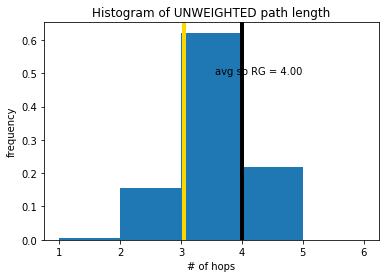

In [197]:
# shortest path
#quanti hop servono a collegare due nodi nella rete
# si calcola lo shortest path medio
# campionamento dei nodi
# grafo iniziale
src = sample(list(gc.vs), 1000)
trg = sample(list(gc.vs), 1000)
n_hops_u = gc.shortest_paths(source = src, target = trg, weights = None)
n_hops_u = np.array(n_hops_u).flatten()
gc_sp_avg = mean(n_hops_u)
gc_sp_diametro = max(n_hops_u)


plt.figure(6)
nhops_densities,_,_ = plt.hist(n_hops_u, bins = range(1,max(n_hops_u)+3), density = True)
_ = plt.axvline(mean(n_hops_u), color = 'gold', linewidth = 4)
_ = plt.xlabel("# of hops")
_ = plt.ylabel("frequency")
_ = plt.title("Histogram of UNWEIGHTED path length")
plt.savefig("shortest_path.png")

# Typically average shortest path
ex_avg_sp = np.log10(gc.vcount())
_ = plt.axvline(ex_avg_sp, color = 'black', linewidth = 4)
_ = plt.text(max(n_hops_u)+1, 0.8*max(nhops_densities), "avg sp RG = {:.2f}".format(ex_avg_sp),
             color = "black", horizontalalignment = "right")

# Erdos Renyi
er_src = sample(list(er_gc.vs), 1000)
er_trg = sample(list(er_gc.vs), 1000)
er_gc_sp_avg = mean(np.array(er_gc.shortest_paths(source = er_src, target = er_trg, weights = None)).flatten())
er_gc_sp_diametro = max(np.array(er_gc.shortest_paths(source = er_src, target = er_trg, weights = None)).flatten())

#Barabasi-Albert
# on a subset of the nodes, as otherwise it will take forever to compute
ba_src = sample(list(ba_gc.vs), 1000)
ba_trg = sample(list(ba_gc.vs), 1000)
ba_gc_sp_avg = mean(np.array(ba_gc.shortest_paths(ba_src, ba_trg)).flatten())
ba_gc_sp_diametro = max(np.array(ba_gc.shortest_paths(ba_src, ba_trg)).flatten())

# Watts-Strogatz
# on a subset of the nodes, as otherwise it will take forever to compute
ws_src = sample(list(ws_gc.vs), 1000)
ws_trg = sample(list(ws_gc.vs), 1000)
ws_gc_sp_avg = mean(np.array(ws_fb.shortest_paths(ws_src, ws_trg)).flatten())
ws_gc_sp_diametro = max(np.array(ba_gc.shortest_paths(ba_src, ba_trg)).flatten())


print("FB net shortest path medio: {}".format(gc_sp_avg))
print("ER net shortest path medio: {}".format(er_gc_sp_avg))
print("PA net shortest path medio: {}".format(ba_gc_sp_avg))
print("WS net shortest path medio: {}".format(ws_gc_sp_avg))

print("FB net DIAMETRO: {}".format(gc_sp_diametro))
print("ER net DIAMETRO: {}".format(er_gc_sp_diametro))
print("PA net DIAMETRO: {}".format(ba_gc_sp_diametro))
print("WS net DIAMETRO: {}".format(ws_gc_sp_diametro))

#### Power low check

In [198]:
# Gamma < 2 ---> SP medio = costante
# 2 < Gamma < 3 ---> SP medio = ln ln N
# Gamma > 3 ---> SP medio = ln N / ( ln ln N)
if exp_pl_auto < 2:
    print ("Regime ANOMALO, lo shortesp path è na costante.")
elif 2 < exp_pl_auto < 3:
    print ("Regime Scale Free, calcolo lo shortest path su base Gamma")
    log(log(N))
else:
    print ("Regime RANDOM (esponenziale), calcolo lo shortest path su base Gamma")
    log(N)/log(log(N))
    

Regime RANDOM (esponenziale), calcolo lo shortest path su base Gamma


4.148191313801706